In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from joblib import dump,load

plt.style.use('ggplot')
plt.rc(
    'figure',
    autolayout=True,
    figsize=(11,4)
)

plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=20,
    titlepad=10
)

In [3]:
# Loading the dataset
dataframe = pd.read_csv('msft_raw.csv',
                        usecols=['DATE','OPCP','HPCP','LPCP','CPCP','ACPCP','VTCP', 'MPN5P'], 
                        index_col='DATE')

dataframe.index = pd.to_datetime(dataframe.index)
dataframe.head()

,OPCP,HPCP,LPCP,CPCP,ACPCP,VTCP,MPN5P
DATE,,,,,,,
2000-02-29,45.87500,45.875000,44.43750,44.68750,27.880445,58437400,46.765625
2000-03-01,44.81250,47.046875,44.46875,45.40625,28.328880,106889800,47.070312
2000-03-02,45.90625,47.687500,45.56250,46.68750,29.128248,106932600,47.656250
2000-03-03,47.37500,49.437500,46.93750,48.06250,29.986110,101435200,48.000000
2000-03-06,48.00000,48.687500,45.06250,45.31250,28.270390,93609400,48.750000


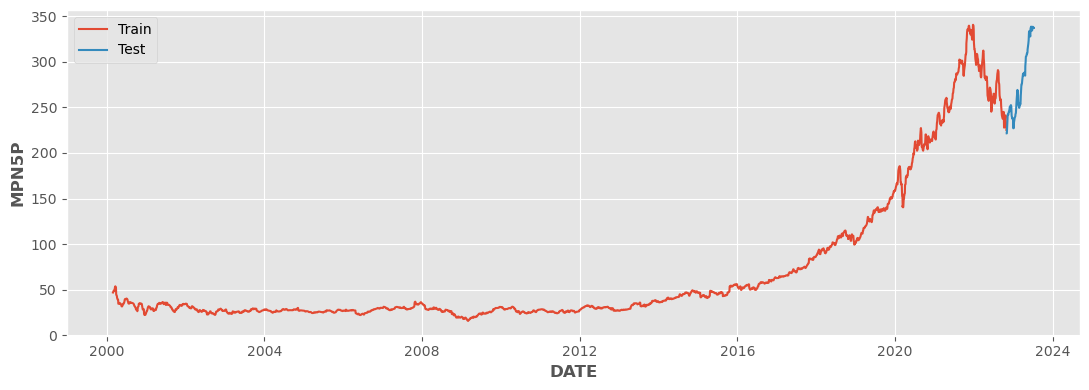

In [4]:
train_end = '2022-10-28'
train = dataframe.loc[:train_end,:]
test = dataframe.loc[train_end:,:].drop(train_end,axis=0)

#save test and train set for later use
train.to_csv('msft_raw_train.csv')
test.to_csv('msft_raw_test.csv')

ax = sns.lineplot(train['MPN5P'], label='Train')
sns.lineplot(test['MPN5P'],ax=ax, label='Test')

plt.legend()

In [5]:
train = train.reset_index()

#### Apply Cross Validation on Train Set

Train shape: (955, 6) | Test Shape: (950, 6)
For fold 0 RMSE: 1.0585988098146535


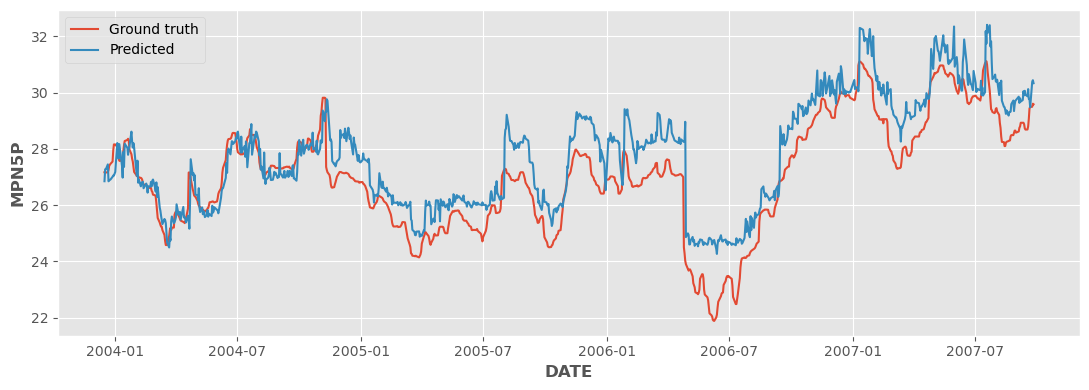

Train shape: (1905, 6) | Test Shape: (950, 6)
For fold 1 RMSE: 1.6848013307826377


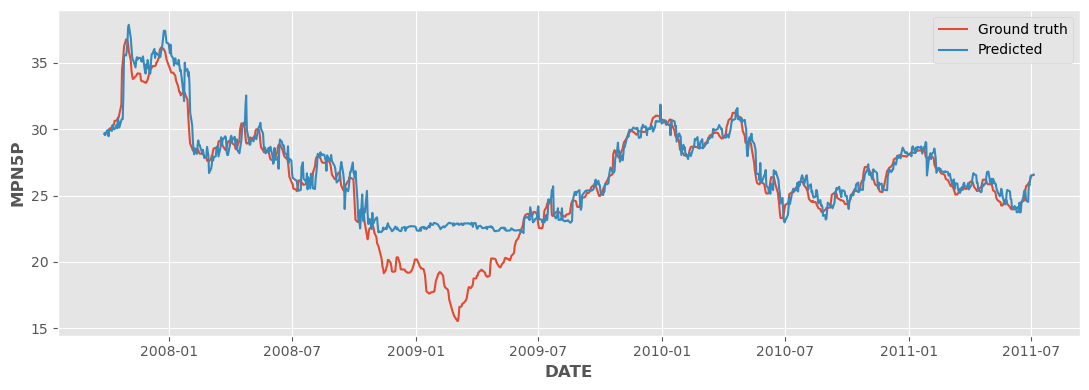

Train shape: (2855, 6) | Test Shape: (950, 6)
For fold 2 RMSE: 1.3044050950841681


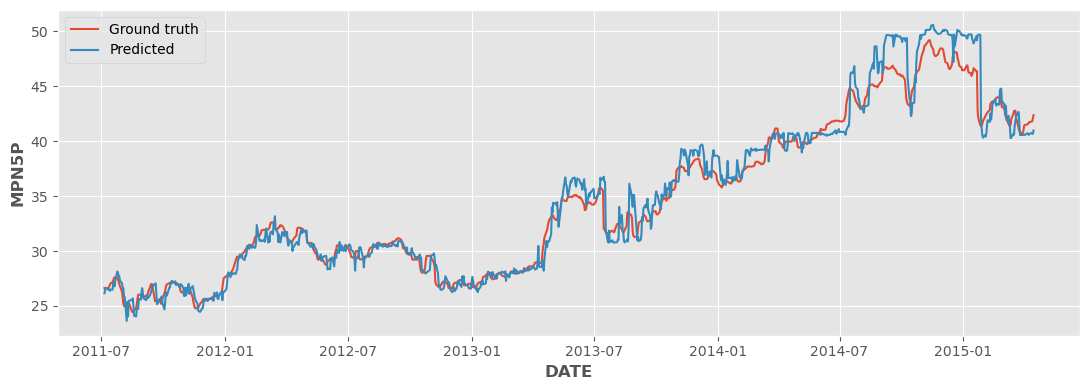

Train shape: (3805, 6) | Test Shape: (950, 6)
For fold 3 RMSE: 32.169705589964266


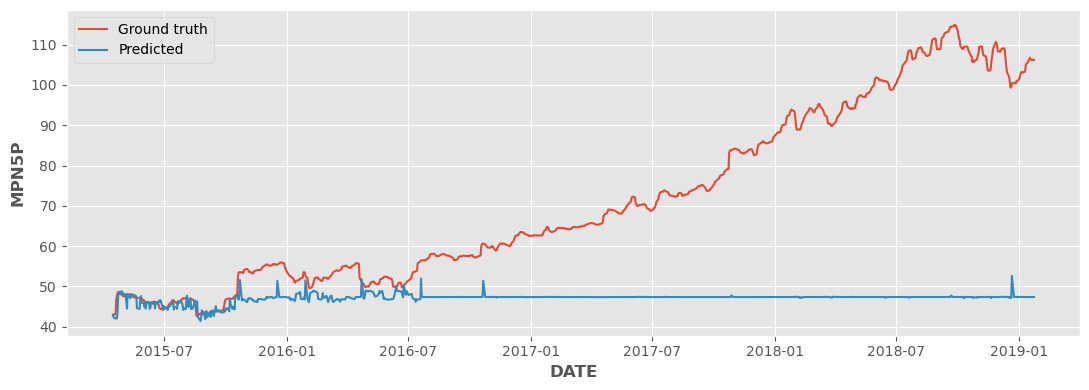

Train shape: (4755, 6) | Test Shape: (950, 6)
For fold 4 RMSE: 124.14752783092499


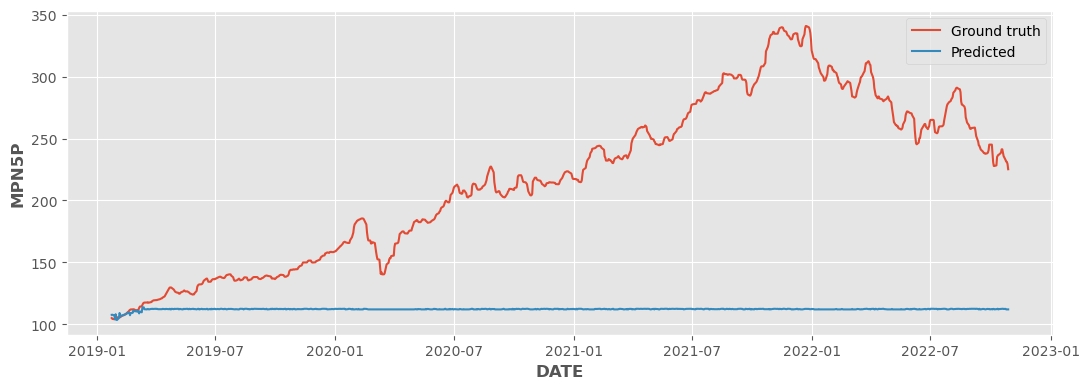

Average RMSE in 5 Folds: 32.07300773131414


In [9]:
features = ['OPCP','HPCP','LPCP','CPCP','ACPCP','VTCP']
target = 'MPN5P'

plot = True

tss = TimeSeriesSplit(n_splits=5)
rmse_scores = []
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(tss.split(train)):
    train_dates, val_dates = train.loc[train_idx,'DATE'], train.loc[val_idx,'DATE']
    X_train, y_train = train.loc[train_idx, features], train.loc[train_idx, target]
    X_val, y_val = train.loc[val_idx, features], train.loc[val_idx,target]
    print("Train shape:", X_train.shape, "|", "Test Shape:", X_val.shape)
    # Train
    model = RandomForestRegressor()
    model.fit(X_train,y_train)
    # Run predictions for val set and calculate the scores
    y_pred = pd.Series(model.predict(X_val),index=val_dates)

    rmse = np.sqrt(mean_squared_error(y_true=y_val, y_pred=y_pred))
    print(f'For fold {fold} RMSE: {rmse}')
    rmse_scores.append(rmse)
    y_val.index = val_dates
    
    if plot:
        ax = sns.lineplot(y_val, label='Ground truth')
        sns.lineplot(y_pred, label='Predicted')
        plt.show()

    #save fitted model to models folder
    dump(model, f'C:/Users/HP/OneDrive/Desktop/Proceedit/RFA-Random_Forest_Algorithm.Bot-API_0.00/notebooks/models/RFA_model_fold_{fold}.joblib')
    

print(f'Average RMSE in 5 Folds: {np.mean(rmse_scores)}')

#### Load the model trained on last fold

In [25]:
RFA_model = load('C:\/Users/HP/OneDrive/Desktop/Proceedit/RFA-Random_Forest_Algorithm.Bot-API_0.00/notebooks/models/RFA_model_fold_4.joblib')   

# run prediction on test set
predictions = pd.Series(RFA_model.predict(test[features]), index=test.index)

#calculate rmse
rmse = np.sqrt(mean_squared_error(y_true=test[target], y_pred=predictions))
print(rmse)

168.39875076003676


<AxesSubplot: xlabel='DATE', ylabel='MPN5P'>

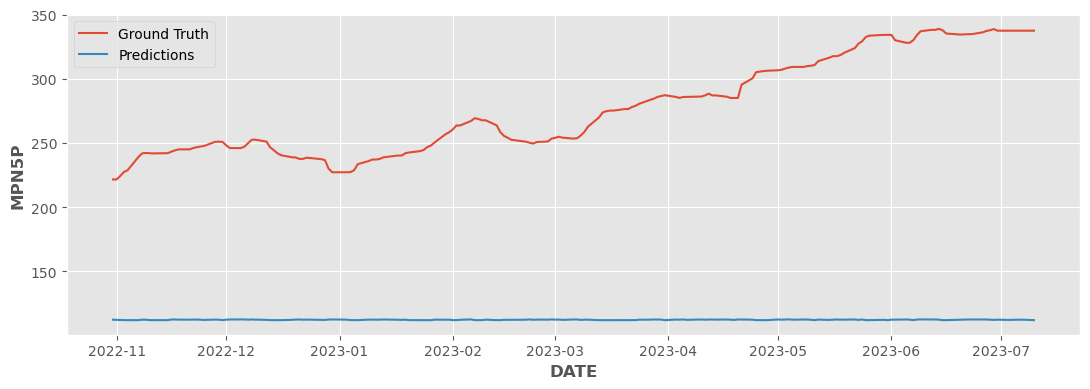

In [26]:
ax = sns.lineplot(test['MPN5P'], label='Ground Truth')
sns.lineplot(predictions,label='Predictions', ax=ax)